In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from xgboost import XGBRegressor
import matplotlib.pyplot as plt

### Importing data

In [80]:
fat_df = pd.read_csv('data/data_clean/fat_data_clean.csv')
kcal_df = pd.read_csv('data/data_clean/kcal_data_clean.csv')
kg_df = pd.read_csv('data/data_clean/kg_data_clean.csv')
protein_df = pd.read_csv('data/data_clean/protein_data_clean.csv')

## Identifying Multicollinearity in Data

In [64]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [65]:
# Using fat_df just as preliminary dataset to identify multicollinearity
fat_df = fat_df.drop(['Country'], axis=1)

X = fat_df.iloc[:, :-6]
X_col = X.copy()
X = MinMaxScaler().fit_transform(X)
y = fat_df['Deaths']


vif_data = pd.DataFrame()
vif_data["feature"] = X_col.columns

In [66]:
# Training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 5)

# Initial results
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X, i)
                          for i in range(len(X_col.columns))]

In [67]:
#Identified that:
# - Vegetable Oil is highly correlative with Vegetable Products attribute
# - Milk and Animal Fats might correlate and fit with Animal Products
vif_data.sort_values('VIF')

,feature,VIF
18,Sugar & Sweeteners_f,1.894525e+00
3,"Aquatic Products, Other_f",3.423765e+00
0,Alcoholic Beverages_f,3.743534e+00
23,Obesity,8.263887e+00
17,Sugar Crops_f,1.079844e+01
9,Miscellaneous_f,1.321336e+02
11,Offals_f,1.421459e+03
22,Vegetables_f,2.050995e+03
15,Starchy Roots_f,3.085332e+03
13,Pulses_f,3.408131e+03


## Using XGBoost for Feature Importance

### Using Food Supply in Kcal dataset

In [68]:
# Removing Country column due to it being categorical and not providing much information
kcal_df = kcal_df[['Vegetal Products_kcal', 'Fish, Seafood_kcal', 'Spices_kcal', 
                   'Offals_kcal', 'Vegetables_kcal','Animal Products_kcal',
                   'Alcoholic Beverages_kcal','Sugar & Sweeteners_kcal','Confirmed','Deaths', 'Recovered']]

#kcal_df = kcal_df.drop(['Country', 'Obesity'], axis=1)
kcal_df.describe()

,Vegetal Products_kcal,"Fish, Seafood_kcal",Spices_kcal,Offals_kcal,Vegetables_kcal,Animal Products_kcal,Alcoholic Beverages_kcal,Sugar & Sweeteners_kcal,Confirmed,Deaths,Recovered
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,40.741763,0.607802,0.186888,0.142634,1.082252,9.259680,1.341392,4.866630,2.021972,0.039370,1.452356
std,4.766396,0.549763,0.239864,0.110741,0.653259,4.766646,1.068834,2.120514,2.360454,0.048718,1.927617
min,27.708900,0.000000,0.000000,0.000000,0.095700,1.623700,0.000000,0.678600,0.000312,0.000000,0.000000
25%,36.841775,0.237500,0.037625,0.078475,0.602000,5.031950,0.388900,3.435525,0.140976,0.002013,0.099107
50%,41.062700,0.466750,0.087350,0.118250,1.001300,8.933250,1.244600,4.793350,1.011570,0.011998,0.475402
75%,44.985600,0.861950,0.233800,0.179025,1.349850,13.160125,2.042250,6.383900,3.487069,0.069503,2.622874
max,48.386400,4.418300,1.220200,0.801500,3.352400,22.291100,5.157400,9.549200,10.408199,0.185428,9.039871


##### Feature Importance for Confirmed Attribute

In [69]:
# Dividing the data between X and y of interest
X = kcal_df.drop(['Confirmed','Deaths', 'Recovered'], axis=1)
# X_col = X.copy()
# X = MinMaxScaler().fit_transform(X)
y = kcal_df['Confirmed'] 

In [70]:
# Training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Training split using K-Fold for cross_val
kfold = KFold(n_splits=10)

# Parameter grid for XGBoost
params = {'gamma': [0.5, 1, 1.5, 2, 5],
          'max_depth': [3, 4, 5], 
          'min_child_weight': [1, 2, 5, 10]
         }

# Create XGBoost model instance
xgb = XGBRegressor()

# Create GridSearch instance
xgb_gs = GridSearchCV(xgb, param_grid=params)
xgb_gs.fit(X, y)

# Metrics and Cross Validation of model
mse = cross_val_score(xgb_gs, X, y, scoring='neg_mean_squared_error', cv=kfold)
rmse = cross_val_score(xgb_gs, X, y, scoring='neg_root_mean_squared_error', cv=kfold)
mae = cross_val_score(xgb_gs, X, y, scoring='neg_mean_absolute_error', cv=kfold)
r2 = cross_val_score(xgb_gs, X, y, scoring='r2', cv=kfold)

print(f"MSE: {-mse.mean()} ({mse.std()})")
print(f"RMSE: {-rmse.mean()} ({rmse.std()})")
print(f"MAE: {-mae.mean()} ({mae.std()})")

MSE: 3.367706643000562 (1.3230440169986173)
RMSE: 1.8001744300399944 (0.35648094539644654)
MAE: 1.2743582639731765 (0.24306872740535615)



Feature Importances:
    0.3171 - Alcoholic Beverages_f
    0.1021 - Animal Products_f
    0.1030 - Animal fats_f
    0.0877 - Aquatic Products, Other_f
    0.1187 - Cereals - Excluding Beer_f
    0.0000 - Eggs_f
    0.1481 - Fish, Seafood_f
    0.1234 - Fruits - Excluding Wine_f


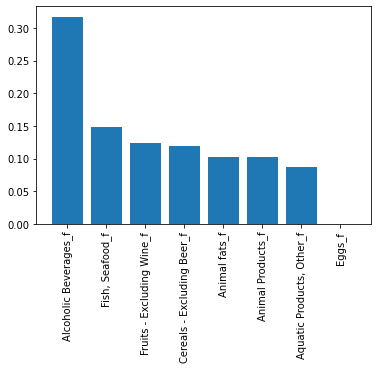

In [71]:
# Get Feature Importance from model
importance = xgb_gs.best_estimator_.feature_importances_


print("\nFeature Importances:")
for item in zip(X_col.columns, xgb_gs.best_estimator_.feature_importances_):
    print("{1:10.4f} - {0}".format(item[0],item[1]))

# Plot feature importance
feat_importance = zip(X_col.columns, importance)
feat_importance = sorted([x for x in feat_importance], key = lambda x: x[1], reverse=True)

plt.bar(*zip(*feat_importance))
plt.xticks(rotation=90)
plt.show()

##### Feature Importance for Deaths Attribute

In [72]:
# Dividing the data between X and y of interest
X = kcal_df.drop(['Confirmed','Deaths', 'Recovered'], axis=1)
# X = kcal_df.iloc[:, :-6]
# X_col = X.copy()

# Scaled data values by a scale of 100 so XGBoost can learn effectively (issues with small data values)
# Did this since we are only using model for feature importance (would not do for prediction model)
y = kcal_df['Deaths']*100

In [73]:
# Training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Training split using K-Fold for cross_val
kfold = KFold(n_splits=10)

# Parameter grid for XGBoost
params = {'gamma': [0.5, 1, 1.5, 2, 5],
          'max_depth': [3, 4, 5],
          'min_child_weight': [1, 2, 5, 10]
         }

# Create XGBoost model instance
xgb = XGBRegressor()

# Create GridSearch instance
xgb_gs = GridSearchCV(xgb, param_grid=params)
xgb_gs.fit(X, y)

# Metrics and Cross Validation of model
mse = cross_val_score(xgb_gs, X, y, scoring='neg_mean_squared_error', cv=kfold)
rmse = cross_val_score(xgb_gs, X, y, scoring='neg_root_mean_squared_error', cv=kfold)
mae = cross_val_score(xgb_gs, X, y, scoring='neg_mean_absolute_error', cv=kfold)
r2 = cross_val_score(xgb_gs, X, y, scoring='r2', cv=kfold)

print(f"MSE: {-mse.mean()} ({mse.std()})")
print(f"RMSE: {-rmse.mean()} ({rmse.std()})")
print(f"MAE: {-mae.mean()} ({mae.std()})")

MSE: 15.942378150245451 (5.500874531264631)
RMSE: 3.9265880044448607 (0.7240751298002003)
MAE: 2.9253019524086175 (0.5580505066460781)



Feature Importances:
    0.3015 - Alcoholic Beverages_f
    0.1858 - Animal Products_f
    0.1134 - Animal fats_f
    0.0864 - Aquatic Products, Other_f
    0.0720 - Cereals - Excluding Beer_f
    0.0949 - Eggs_f
    0.0931 - Fish, Seafood_f
    0.0530 - Fruits - Excluding Wine_f


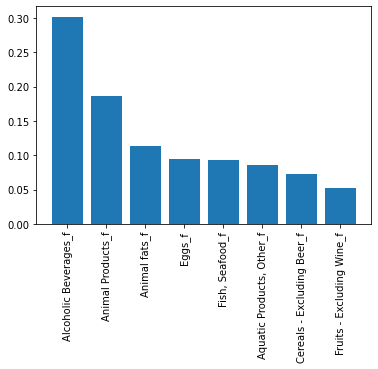

In [74]:
# Get Feature Importance from model
importance = xgb_gs.best_estimator_.feature_importances_


print("\nFeature Importances:")
for item in zip(X_col.columns, xgb_gs.best_estimator_.feature_importances_):
    print("{1:10.4f} - {0}".format(item[0],item[1]))

# Plot feature importance
feat_importance = zip(X_col.columns, importance)
feat_importance = sorted([x for x in feat_importance], key = lambda x: x[1], reverse=True)

plt.bar(*zip(*feat_importance))
plt.xticks(rotation=90)
plt.show()

##### Feature Importance for Recovered Attribute

In [75]:
# Dividing the data between X and y of interest
X = kcal_df.drop(['Confirmed','Deaths', 'Recovered'], axis=1)
# X = kcal_df.iloc[:, :-6]
# X_col = X.copy()
# X = MinMaxScaler().fit_transform(X)
y = kcal_df['Recovered']
y.describe()

count    164.000000
mean       1.452356
std        1.927617
min        0.000000
25%        0.099107
50%        0.475402
75%        2.622874
max        9.039871
Name: Recovered, dtype: float64

In [76]:
# Training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
# Training split using K-Fold for cross_val
kfold = KFold(n_splits=10)

# Parameter grid for XGBoost
params = {'gamma': [0.5, 1, 1.5, 2, 5]
#           'max_depth': [3, 4, 5]
#           'min_child_weight': [1, 2, 5, 10]
         }

# Create XGBoost model instance
xgb = XGBRegressor()

# Create GridSearch instance
xgb_gs = GridSearchCV(xgb, param_grid=params)
xgb_gs.fit(X, y)

# Metrics and Cross Validation of model
mse = cross_val_score(xgb_gs, X, y, scoring='neg_mean_squared_error', cv=kfold)
rmse = cross_val_score(xgb_gs, X, y, scoring='neg_root_mean_squared_error', cv=kfold)
mae = cross_val_score(xgb_gs, X, y, scoring='neg_mean_absolute_error', cv=kfold)
r2 = cross_val_score(xgb_gs, X, y, scoring='r2', cv=kfold)

print(f"MSE: {-mse.mean()} ({mse.std()})")
print(f"RMSE: {-rmse.mean()} ({rmse.std()})")
print(f"MAE: {-mae.mean()} ({mae.std()})")

MSE: 3.176099250415303 (1.1498478562618872)
RMSE: 1.7501231728914959 (0.3364047118033671)
MAE: 1.2074455990257897 (0.22435487397951662)



Feature Importances:
    0.2062 - Alcoholic Beverages_f
    0.2442 - Animal Products_f
    0.1030 - Animal fats_f
    0.0808 - Aquatic Products, Other_f
    0.0788 - Cereals - Excluding Beer_f
    0.0000 - Eggs_f
    0.1619 - Fish, Seafood_f
    0.1252 - Fruits - Excluding Wine_f


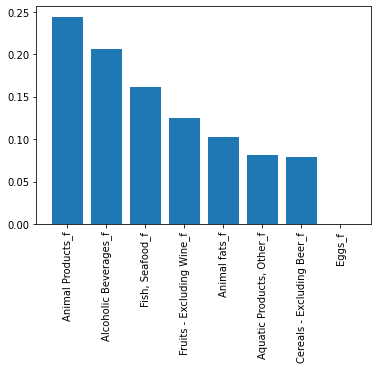

In [77]:
# Get Feature Importance from model
importance = xgb_gs.best_estimator_.feature_importances_


print("\nFeature Importances:")
for item in zip(X_col.columns, xgb_gs.best_estimator_.feature_importances_):
    print("{1:10.4f} - {0}".format(item[0],item[1]))

# Plot feature importance
feat_importance = zip(X_col.columns, importance)
feat_importance = sorted([x for x in feat_importance], key = lambda x: x[1], reverse=True)

plt.bar(*zip(*feat_importance))
plt.xticks(rotation=90)
plt.show()

### Using Food Supply in Kg dataset

In [81]:
# Removing Country column due to it being categorical and not providing much information
kg_df = kg_df[['Vegetal Products_kg', 'Fish, Seafood_kg', 'Spices_kg', 
                   'Offals_kg', 'Vegetables_kg','Animal Products_kg',
                   'Alcoholic Beverages_kg','Sugar & Sweeteners_kg','Confirmed','Deaths', 'Recovered']]
kg_df

,Vegetal Products_kg,"Fish, Seafood_kg",Spices_kg,Offals_kg,Vegetables_kg,Animal Products_kg,Alcoholic Beverages_kg,Sugar & Sweeteners_kg,Confirmed,Deaths,Recovered
0,40.5645,0.0350,0.0574,0.2057,6.7642,9.4341,0.0014,1.3489,0.142134,0.006186,0.123374
1,31.2304,0.2126,0.0008,0.2324,11.7753,18.7684,1.6719,1.5367,2.967301,0.050951,1.792636
2,40.3651,0.2416,0.0557,0.0870,11.6484,9.6334,0.2711,1.8342,0.244897,0.006558,0.167572
3,45.0722,1.7707,0.0009,0.1550,2.3041,4.9278,5.8087,1.8495,0.061687,0.001461,0.056808
4,33.3233,4.1489,0.1524,0.2219,5.4495,16.6613,3.5764,3.8749,0.293878,0.007143,0.190816
...,...,...,...,...,...,...,...,...,...,...,...
159,35.2416,0.9456,0.0009,0.2078,4.1474,14.7565,2.5952,3.4106,0.452585,0.004287,0.424399
160,41.4232,2.6392,0.2074,0.4149,11.9508,8.5765,1.4591,1.2846,0.002063,0.000036,0.001526
161,44.2126,0.5240,0.0347,0.2827,3.2135,5.7874,0.0364,5.0468,0.007131,0.002062,0.004788
162,43.9789,1.6924,0.0478,0.3048,3.4649,6.0197,5.7360,1.5632,0.334133,0.004564,0.290524


##### Feature Importance for Confirmed Attribute

In [82]:
# Dividing the data between X and y of interest
X = kg_df.drop(['Confirmed','Deaths', 'Recovered'], axis=1)
# kg_df.iloc[:, :-6]
# X_col = X.copy()
y = kg_df['Confirmed'] 

In [83]:
# Training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Training split using K-Fold for cross_val
kfold = KFold(n_splits=10)

# Parameter grid for XGBoost
params = {'gamma': [0.5, 1, 1.5, 2, 5],
          'max_depth': [3, 4, 5],
          'min_child_weight': [1, 2, 5, 10]
         }

# Create XGBoost model instance
xgb = XGBRegressor()

# Create GridSearch instance
xgb_gs = GridSearchCV(xgb, param_grid=params)
xgb_gs.fit(X, y)

# Metrics and Cross Validation of model
mse = cross_val_score(xgb_gs, X, y, scoring='neg_mean_squared_error', cv=kfold)
rmse = cross_val_score(xgb_gs, X, y, scoring='neg_root_mean_squared_error', cv=kfold)
mae = cross_val_score(xgb_gs, X, y, scoring='neg_mean_absolute_error', cv=kfold)
r2 = cross_val_score(xgb_gs, X, y, scoring='r2', cv=kfold)

print(f"MSE: {-mse.mean()} ({mse.std()})")
print(f"RMSE: {-rmse.mean()} ({rmse.std()})")
print(f"MAE: {-mae.mean()} ({mae.std()})")

MSE: 3.904777898271269 (2.3273257305896107)
RMSE: 1.895081120007124 (0.5598619891221529)
MAE: 1.3982728795284496 (0.3451024602643835)



Feature Importances:
    0.4468 - Alcoholic Beverages_f
    0.0971 - Animal Products_f
    0.0438 - Animal fats_f
    0.1390 - Aquatic Products, Other_f
    0.1264 - Cereals - Excluding Beer_f
    0.0000 - Eggs_f
    0.0911 - Fish, Seafood_f
    0.0558 - Fruits - Excluding Wine_f


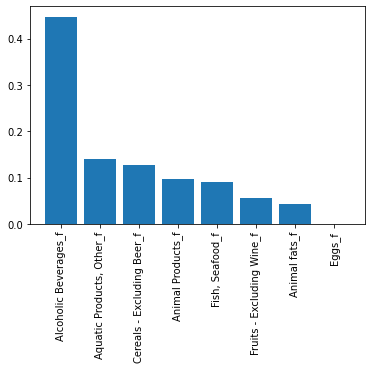

In [84]:
# Get Feature Importance from model
importance = xgb_gs.best_estimator_.feature_importances_


print("\nFeature Importances:")
for item in zip(X_col.columns, xgb_gs.best_estimator_.feature_importances_):
    print("{1:10.4f} - {0}".format(item[0],item[1]))

# Plot feature importance
feat_importance = zip(X_col.columns, importance)
feat_importance = sorted([x for x in feat_importance], key = lambda x: x[1], reverse=True)

plt.bar(*zip(*feat_importance))
plt.xticks(rotation=90)
plt.show()

##### Feature Importance for Deaths Attribute

In [85]:
# Dividing the data between X and y of interest
X = kg_df.drop(['Confirmed','Deaths', 'Recovered'], axis=1)
# kg_df.iloc[:, :-6]
# X_col = X.copy()
y = kg_df['Deaths']*100

In [86]:
# Training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Training split using K-Fold for cross_val
kfold = KFold(n_splits=10)

# Parameter grid for XGBoost
params = {'gamma': [0.5, 1, 1.5, 2, 5],
          'max_depth': [3, 4, 5],
          'min_child_weight': [1, 2, 5, 10]
         }

# Create XGBoost model instance
xgb = XGBRegressor()

# Create GridSearch instance
xgb_gs = GridSearchCV(xgb, param_grid=params)
xgb_gs.fit(X, y)

# Metrics and Cross Validation of model
mse = cross_val_score(xgb_gs, X, y, scoring='neg_mean_squared_error', cv=kfold)
rmse = cross_val_score(xgb_gs, X, y, scoring='neg_root_mean_squared_error', cv=kfold)
mae = cross_val_score(xgb_gs, X, y, scoring='neg_mean_absolute_error', cv=kfold)
r2 = cross_val_score(xgb_gs, X, y, scoring='r2', cv=kfold)

print(f"MSE: {-mse.mean()} ({mse.std()})")
print(f"RMSE: {-rmse.mean()} ({rmse.std()})")
print(f"MAE: {-mae.mean()} ({mae.std()})")

MSE: 17.36076132731088 (7.729312426137659)
RMSE: 4.053186214248244 (0.9656307989800608)
MAE: 3.0925043124570477 (0.7119285566140796)



Feature Importances:
    0.4112 - Alcoholic Beverages_f
    0.1120 - Animal Products_f
    0.0509 - Animal fats_f
    0.0597 - Aquatic Products, Other_f
    0.1002 - Cereals - Excluding Beer_f
    0.0570 - Eggs_f
    0.1591 - Fish, Seafood_f
    0.0499 - Fruits - Excluding Wine_f


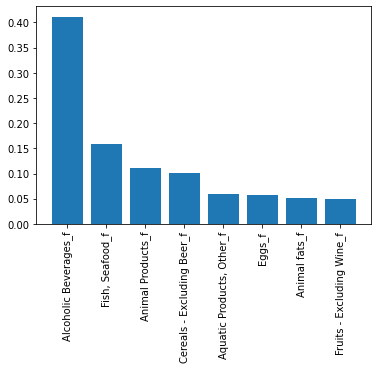

In [87]:
# Get Feature Importance from model
importance = xgb_gs.best_estimator_.feature_importances_


print("\nFeature Importances:")
for item in zip(X_col.columns, xgb_gs.best_estimator_.feature_importances_):
    print("{1:10.4f} - {0}".format(item[0],item[1]))

# Plot feature importance
feat_importance = zip(X_col.columns, importance)
feat_importance = sorted([x for x in feat_importance], key = lambda x: x[1], reverse=True)

plt.bar(*zip(*feat_importance))
plt.xticks(rotation=90)
plt.show()

##### Feature Importance for Recovered Attribute

In [88]:
# Dividing the data between X and y of interest
X = kg_df.drop(['Confirmed','Deaths', 'Recovered'], axis=1)
# kg_df.iloc[:, :-6]
# X_col = X.copy()
y = kg_df['Recovered']

In [89]:
# Training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Training split using K-Fold for cross_val
kfold = KFold(n_splits=10)

# Parameter grid for XGBoost
params = {'gamma': [0.5, 1, 1.5, 2, 5]
#           'max_depth': [3, 4, 5]
#           'min_child_weight': [1, 2, 5, 10]
         }


# Create XGBoost model instance
xgb = XGBRegressor()

# Create GridSearch instance
xgb_gs = GridSearchCV(xgb, param_grid=params)
xgb_gs.fit(X, y)

# Metrics and Cross Validation of model
mse = cross_val_score(xgb_gs, X, y, scoring='neg_mean_squared_error', cv=kfold)
rmse = cross_val_score(xgb_gs, X, y, scoring='neg_root_mean_squared_error', cv=kfold)
mae = cross_val_score(xgb_gs, X, y, scoring='neg_mean_absolute_error', cv=kfold)
r2 = cross_val_score(xgb_gs, X, y, scoring='r2', cv=kfold)

print(f"MSE: {-mse.mean()} ({mse.std()})")
print(f"RMSE: {-rmse.mean()} ({rmse.std()})")
print(f"MAE: {-mae.mean()} ({mae.std()})")

MSE: 4.043329287865214 (1.9065250790135113)
RMSE: 1.9714407352647687 (0.3959175611209019)
MAE: 1.3828995560908024 (0.27505148703184984)



Feature Importances:
    0.2428 - Alcoholic Beverages_f
    0.1601 - Animal Products_f
    0.0959 - Animal fats_f
    0.1497 - Aquatic Products, Other_f
    0.0789 - Cereals - Excluding Beer_f
    0.0000 - Eggs_f
    0.1567 - Fish, Seafood_f
    0.1159 - Fruits - Excluding Wine_f


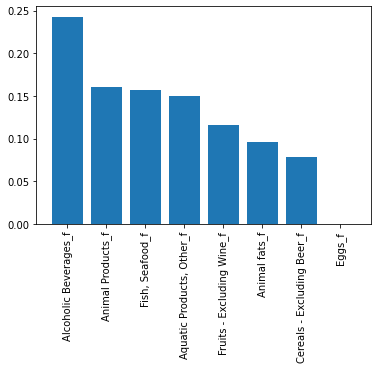

In [90]:
# Get Feature Importance from model
importance = xgb_gs.best_estimator_.feature_importances_


print("\nFeature Importances:")
for item in zip(X_col.columns, xgb_gs.best_estimator_.feature_importances_):
    print("{1:10.4f} - {0}".format(item[0],item[1]))

# Plot feature importance
feat_importance = zip(X_col.columns, importance)
feat_importance = sorted([x for x in feat_importance], key = lambda x: x[1], reverse=True)

plt.bar(*zip(*feat_importance))
plt.xticks(rotation=90)
plt.show()

### Using Protein Supply dataset

In [92]:
# Removing Country column due to it being categorical and not providing much information
protein_df = protein_df[['Vegetal Products_p', 'Fish, Seafood_p', 'Spices_p', 
                   'Offals_p', 'Vegetables_p','Animal Products_p',
                   'Alcoholic Beverages_p','Sugar & Sweeteners_p','Confirmed','Deaths', 'Recovered']]
protein_df

,Vegetal Products_p,"Fish, Seafood_p",Spices_p,Offals_p,Vegetables_p,Animal Products_p,Alcoholic Beverages_p,Sugar & Sweeteners_p,Confirmed,Deaths,Recovered
0,40.2477,0.0647,0.1664,0.5916,1.1370,9.7523,0.0000,0.0000,0.142134,0.006186,0.123374
1,22.2552,0.6274,0.0000,1.1084,3.2456,27.7469,0.1840,0.0042,2.967301,0.050951,1.792636
2,36.1694,0.6350,0.1776,0.3283,3.1267,13.8360,0.0323,0.0000,0.244897,0.006558,0.167572
3,34.7782,5.4436,0.0000,0.8133,0.8133,15.2311,0.6285,0.0092,0.061687,0.001461,0.056808
4,16.8161,8.2146,0.3438,0.8534,1.6024,33.1901,0.1535,0.0000,0.293878,0.007143,0.190816
...,...,...,...,...,...,...,...,...,...,...,...
159,27.4545,2.6477,0.0000,0.7641,1.0129,22.5411,0.1955,0.0178,0.452585,0.004287,0.424399
160,29.5617,5.7435,0.5221,1.6442,3.7216,20.4466,0.1555,0.0056,0.002063,0.000036,0.001526
161,39.9831,0.9392,0.0657,0.7232,0.5448,10.0122,0.0000,0.0000,0.007131,0.002062,0.004788
162,40.1117,3.0126,0.0846,0.9139,0.8039,9.8925,0.4824,0.0000,0.334133,0.004564,0.290524


##### Feature Importance for Confirmed Attribute

In [93]:
# Dividing the data between X and y of interest
X = protein_df.drop(['Confirmed','Deaths', 'Recovered'], axis=1)
# X = protein_df.iloc[:, :-6]
# X_col = X.copy()
y = protein_df['Confirmed'] 

In [94]:
# Training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Training split using K-Fold for cross_val
kfold = KFold(n_splits=10)

# Parameter grid for XGBoost
params = {'gamma': [0.5, 1, 1.5, 2, 5],
          'max_depth': [3, 4, 5],
          'min_child_weight': [1, 2, 5, 10]
         }


# Create XGBoost model instance
xgb = XGBRegressor()

# Create GridSearch instance
xgb_gs = GridSearchCV(xgb, param_grid=params)
xgb_gs.fit(X, y)

# Metrics and Cross Validation of model
mse = cross_val_score(xgb_gs, X, y, scoring='neg_mean_squared_error', cv=kfold)
rmse = cross_val_score(xgb_gs, X, y, scoring='neg_root_mean_squared_error', cv=kfold)
mae = cross_val_score(xgb_gs, X, y, scoring='neg_mean_absolute_error', cv=kfold)
r2 = cross_val_score(xgb_gs, X, y, scoring='r2', cv=kfold)

print(f"MSE: {-mse.mean()} ({mse.std()})")
print(f"RMSE: {-rmse.mean()} ({rmse.std()})")
print(f"MAE: {-mae.mean()} ({mae.std()})")

MSE: 3.786337437452547 (1.367080359092334)
RMSE: 1.913414136770891 (0.35381319740486267)
MAE: 1.3767943998903556 (0.2602050263905295)



Feature Importances:
    0.2970 - Alcoholic Beverages_f
    0.1620 - Animal Products_f
    0.0852 - Animal fats_f
    0.0583 - Aquatic Products, Other_f
    0.0805 - Cereals - Excluding Beer_f
    0.0000 - Eggs_f
    0.0937 - Fish, Seafood_f
    0.2235 - Fruits - Excluding Wine_f


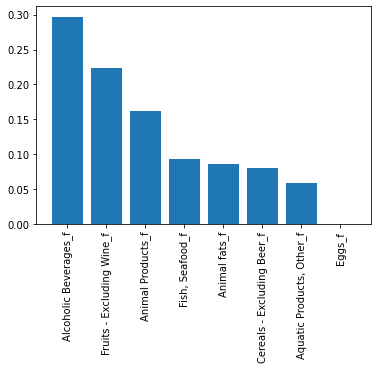

In [95]:
# Get Feature Importance from model
importance = xgb_gs.best_estimator_.feature_importances_


print("\nFeature Importances:")
for item in zip(X_col.columns, xgb_gs.best_estimator_.feature_importances_):
    print("{1:10.4f} - {0}".format(item[0],item[1]))

# Plot feature importance
feat_importance = zip(X_col.columns, importance)
feat_importance = sorted([x for x in feat_importance], key = lambda x: x[1], reverse=True)

plt.bar(*zip(*feat_importance))
plt.xticks(rotation=90)
plt.show()

##### Feature Importance for Deaths Attribute

In [96]:
# Dividing the data between X and y of interest
X = protein_df.drop(['Confirmed','Deaths', 'Recovered'], axis=1)
# X = protein_df.iloc[:, :-6]
# X_col = X.copy()
y = protein_df['Deaths']*100

In [97]:
# Training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Training split using K-Fold for cross_val
kfold = KFold(n_splits=10)

# Parameter grid for XGBoost
params = {'gamma': [0.5, 1, 1.5, 2, 5],
          'max_depth': [3, 4, 5],
          'min_child_weight': [1, 2, 5, 10]
         }

# Create XGBoost model instance
xgb = XGBRegressor()

# Create GridSearch instance
xgb_gs = GridSearchCV(xgb, param_grid=params)
xgb_gs.fit(X, y)

# Metrics and Cross Validation of model
mse = cross_val_score(xgb_gs, X, y, scoring='neg_mean_squared_error', cv=kfold)
rmse = cross_val_score(xgb_gs, X, y, scoring='neg_root_mean_squared_error', cv=kfold)
mae = cross_val_score(xgb_gs, X, y, scoring='neg_mean_absolute_error', cv=kfold)
r2 = cross_val_score(xgb_gs, X, y, scoring='r2', cv=kfold)

print(f"MSE: {-mse.mean()} ({mse.std()})")
print(f"RMSE: {-rmse.mean()} ({rmse.std()})")
print(f"MAE: {-mae.mean()} ({mae.std()})")

MSE: 16.934764936873883 (6.048194979903195)
RMSE: 4.0417138180072945 (0.7741539576872196)
MAE: 3.007872750676497 (0.537608087418861)



Feature Importances:
    0.2179 - Alcoholic Beverages_f
    0.2054 - Animal Products_f
    0.0692 - Animal fats_f
    0.0944 - Aquatic Products, Other_f
    0.0889 - Cereals - Excluding Beer_f
    0.0000 - Eggs_f
    0.0930 - Fish, Seafood_f
    0.2313 - Fruits - Excluding Wine_f


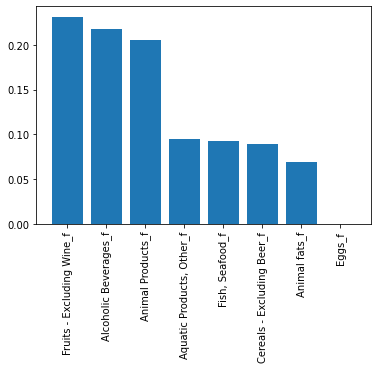

In [98]:
# Get Feature Importance from model
importance = xgb_gs.best_estimator_.feature_importances_


print("\nFeature Importances:")
for item in zip(X_col.columns, xgb_gs.best_estimator_.feature_importances_):
    print("{1:10.4f} - {0}".format(item[0],item[1]))

# Plot feature importance
feat_importance = zip(X_col.columns, importance)
feat_importance = sorted([x for x in feat_importance], key = lambda x: x[1], reverse=True)

plt.bar(*zip(*feat_importance))
plt.xticks(rotation=90)
plt.show()

##### Feature Importance for Recovered Attribute

In [99]:
# Dividing the data between X and y of interest
X = protein_df.drop(['Confirmed','Deaths', 'Recovered'], axis=1)
# X = protein_df.iloc[:, :-6]
# X_col = X.copy()
y = protein_df['Recovered']

In [100]:
# Training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Training split using K-Fold for cross_val
kfold = KFold(n_splits=10)

# Parameter grid for XGBoost
params = {'gamma': [0.5, 1, 1.5, 2, 5]
#           'max_depth': [3, 4, 5]
#           'min_child_weight': [1, 2, 5, 10]
         }


# Create XGBoost model instance
xgb = XGBRegressor()

# Create GridSearch instance
xgb_gs = GridSearchCV(xgb, param_grid=params)
xgb_gs.fit(X, y)

# Metrics and Cross Validation of model
mse = cross_val_score(xgb_gs, X, y, scoring='neg_mean_squared_error', cv=kfold)
rmse = cross_val_score(xgb_gs, X, y, scoring='neg_root_mean_squared_error', cv=kfold)
mae = cross_val_score(xgb_gs, X, y, scoring='neg_mean_absolute_error', cv=kfold)
r2 = cross_val_score(xgb_gs, X, y, scoring='r2', cv=kfold)

print(f"MSE: {-mse.mean()} ({mse.std()})")
print(f"RMSE: {-rmse.mean()} ({rmse.std()})")
print(f"MAE: {-mae.mean()} ({mae.std()})")

MSE: 3.5472976026271645 (1.6794684480935158)
RMSE: 1.837427748749389 (0.4137110957575533)
MAE: 1.2833946465242687 (0.25586781133930336)



Feature Importances:
    0.2056 - Alcoholic Beverages_f
    0.1941 - Animal Products_f
    0.1110 - Animal fats_f
    0.0721 - Aquatic Products, Other_f
    0.0829 - Cereals - Excluding Beer_f
    0.0000 - Eggs_f
    0.2337 - Fish, Seafood_f
    0.1006 - Fruits - Excluding Wine_f


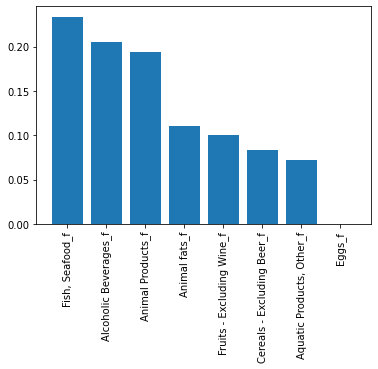

In [101]:
# Get Feature Importance from model
importance = xgb_gs.best_estimator_.feature_importances_


print("\nFeature Importances:")
for item in zip(X_col.columns, xgb_gs.best_estimator_.feature_importances_):
    print("{1:10.4f} - {0}".format(item[0],item[1]))

# Plot feature importance
feat_importance = zip(X_col.columns, importance)
feat_importance = sorted([x for x in feat_importance], key = lambda x: x[1], reverse=True)

plt.bar(*zip(*feat_importance))
plt.xticks(rotation=90)
plt.show()